# flow-poke-transformer/autoseg/explore_minprob_pmotion.py
Run the above in order to save prob motion + sampled points (for testing w/ different thresholds)
# flow-poke-transformer/autoseg/pos_conditioned_flow.py
Run the above in order to save the flows + probe points (for testing w/ the sampled points from the above step)

TODO: run for entityseg_1_image10172

In [6]:
import h5py
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
from autoseg.utils import *
from scipy.ndimage import minimum_filter

# Load the H5 file from flow generation
h5_path = '/ccn2/u/lilianch/external_repos/flow-poke-transformer/autosegp/flows_pmotion12_0.005minprob_8dist_final/entityseg_1_image1011.h5'

with h5py.File(h5_path, 'r') as f:
    image = f['image'][:]
    prob_motion = f['prob_motion'][:]
    sampled_points = f['sampled_points'][:]  # (N, 2) in 64x64 coords
    flows = f['flows'][:]  # (N, num_offsets, 256, 256, 2)
    probe_points = f['probe_points'][:]  # (N, num_offsets, 2, 2)

print(f"Image shape: {image.shape}")
print(f"Flows shape: {flows.shape}")
print(f"Sampled points shape: {sampled_points.shape}")
print(f"Probe points shape: {probe_points.shape}")

Image shape: (256, 256, 3)
Flows shape: (25, 15, 256, 256, 2)
Sampled points shape: (25, 2)
Probe points shape: (25, 15, 2, 2)


# CAN SEE FLOW GENERATIONS HERE: http://node4-ccn2cluster.stanford.edu:8666/cgi-bin/file-explorer/?dir=/ccn2/u/lilianch/external_repos/flow-poke-transformer/autosegp/flows_pmotion12_0.005minprob_8dist_final/vis&patterns_show=*&patterns_highlight=&w=1600&n=1&autoplay=0&showmedia=1

In [7]:
# Reshape flows: (N, num_offsets, 256, 256, 2) -> (256, 256, N*num_offsets, 2)
N, num_offsets, H, W, C = flows.shape
flow_reshaped = flows.transpose(2, 3, 0, 1, 4)  # (256, 256, N, num_offsets, 2)
flow_reshaped = flow_reshaped.reshape(H, W, N * num_offsets, C)  # (256, 256, N*num_offsets, 2)

# Flatten for affinity computation: (256, 256, N*num_offsets, 2) -> (256*256, N*num_offsets*2)
flow_flat_per_pixel = flow_reshaped.reshape(H, W, -1)  # (256, 256, N*num_offsets*2)
flow_flat = flow_flat_per_pixel.reshape(-1, flow_flat_per_pixel.shape[-1])  # (256*256, N*num_offsets*2)

print(f"Flow flat shape: {flow_flat.shape}")

# Compute affinity matrix
flow_tensor = torch.from_numpy(flow_flat).float()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computing affinity matrix on {device}...")
affinity_matrix = compute_affinity_matrix(flow_tensor, device=device, batch_size=2048)
print(f"Affinity matrix shape: {affinity_matrix.shape}")

Flow flat shape: (65536, 750)
Computing affinity matrix on cuda...
Affinity matrix shape: torch.Size([65536, 65536])


Using 25 probe points


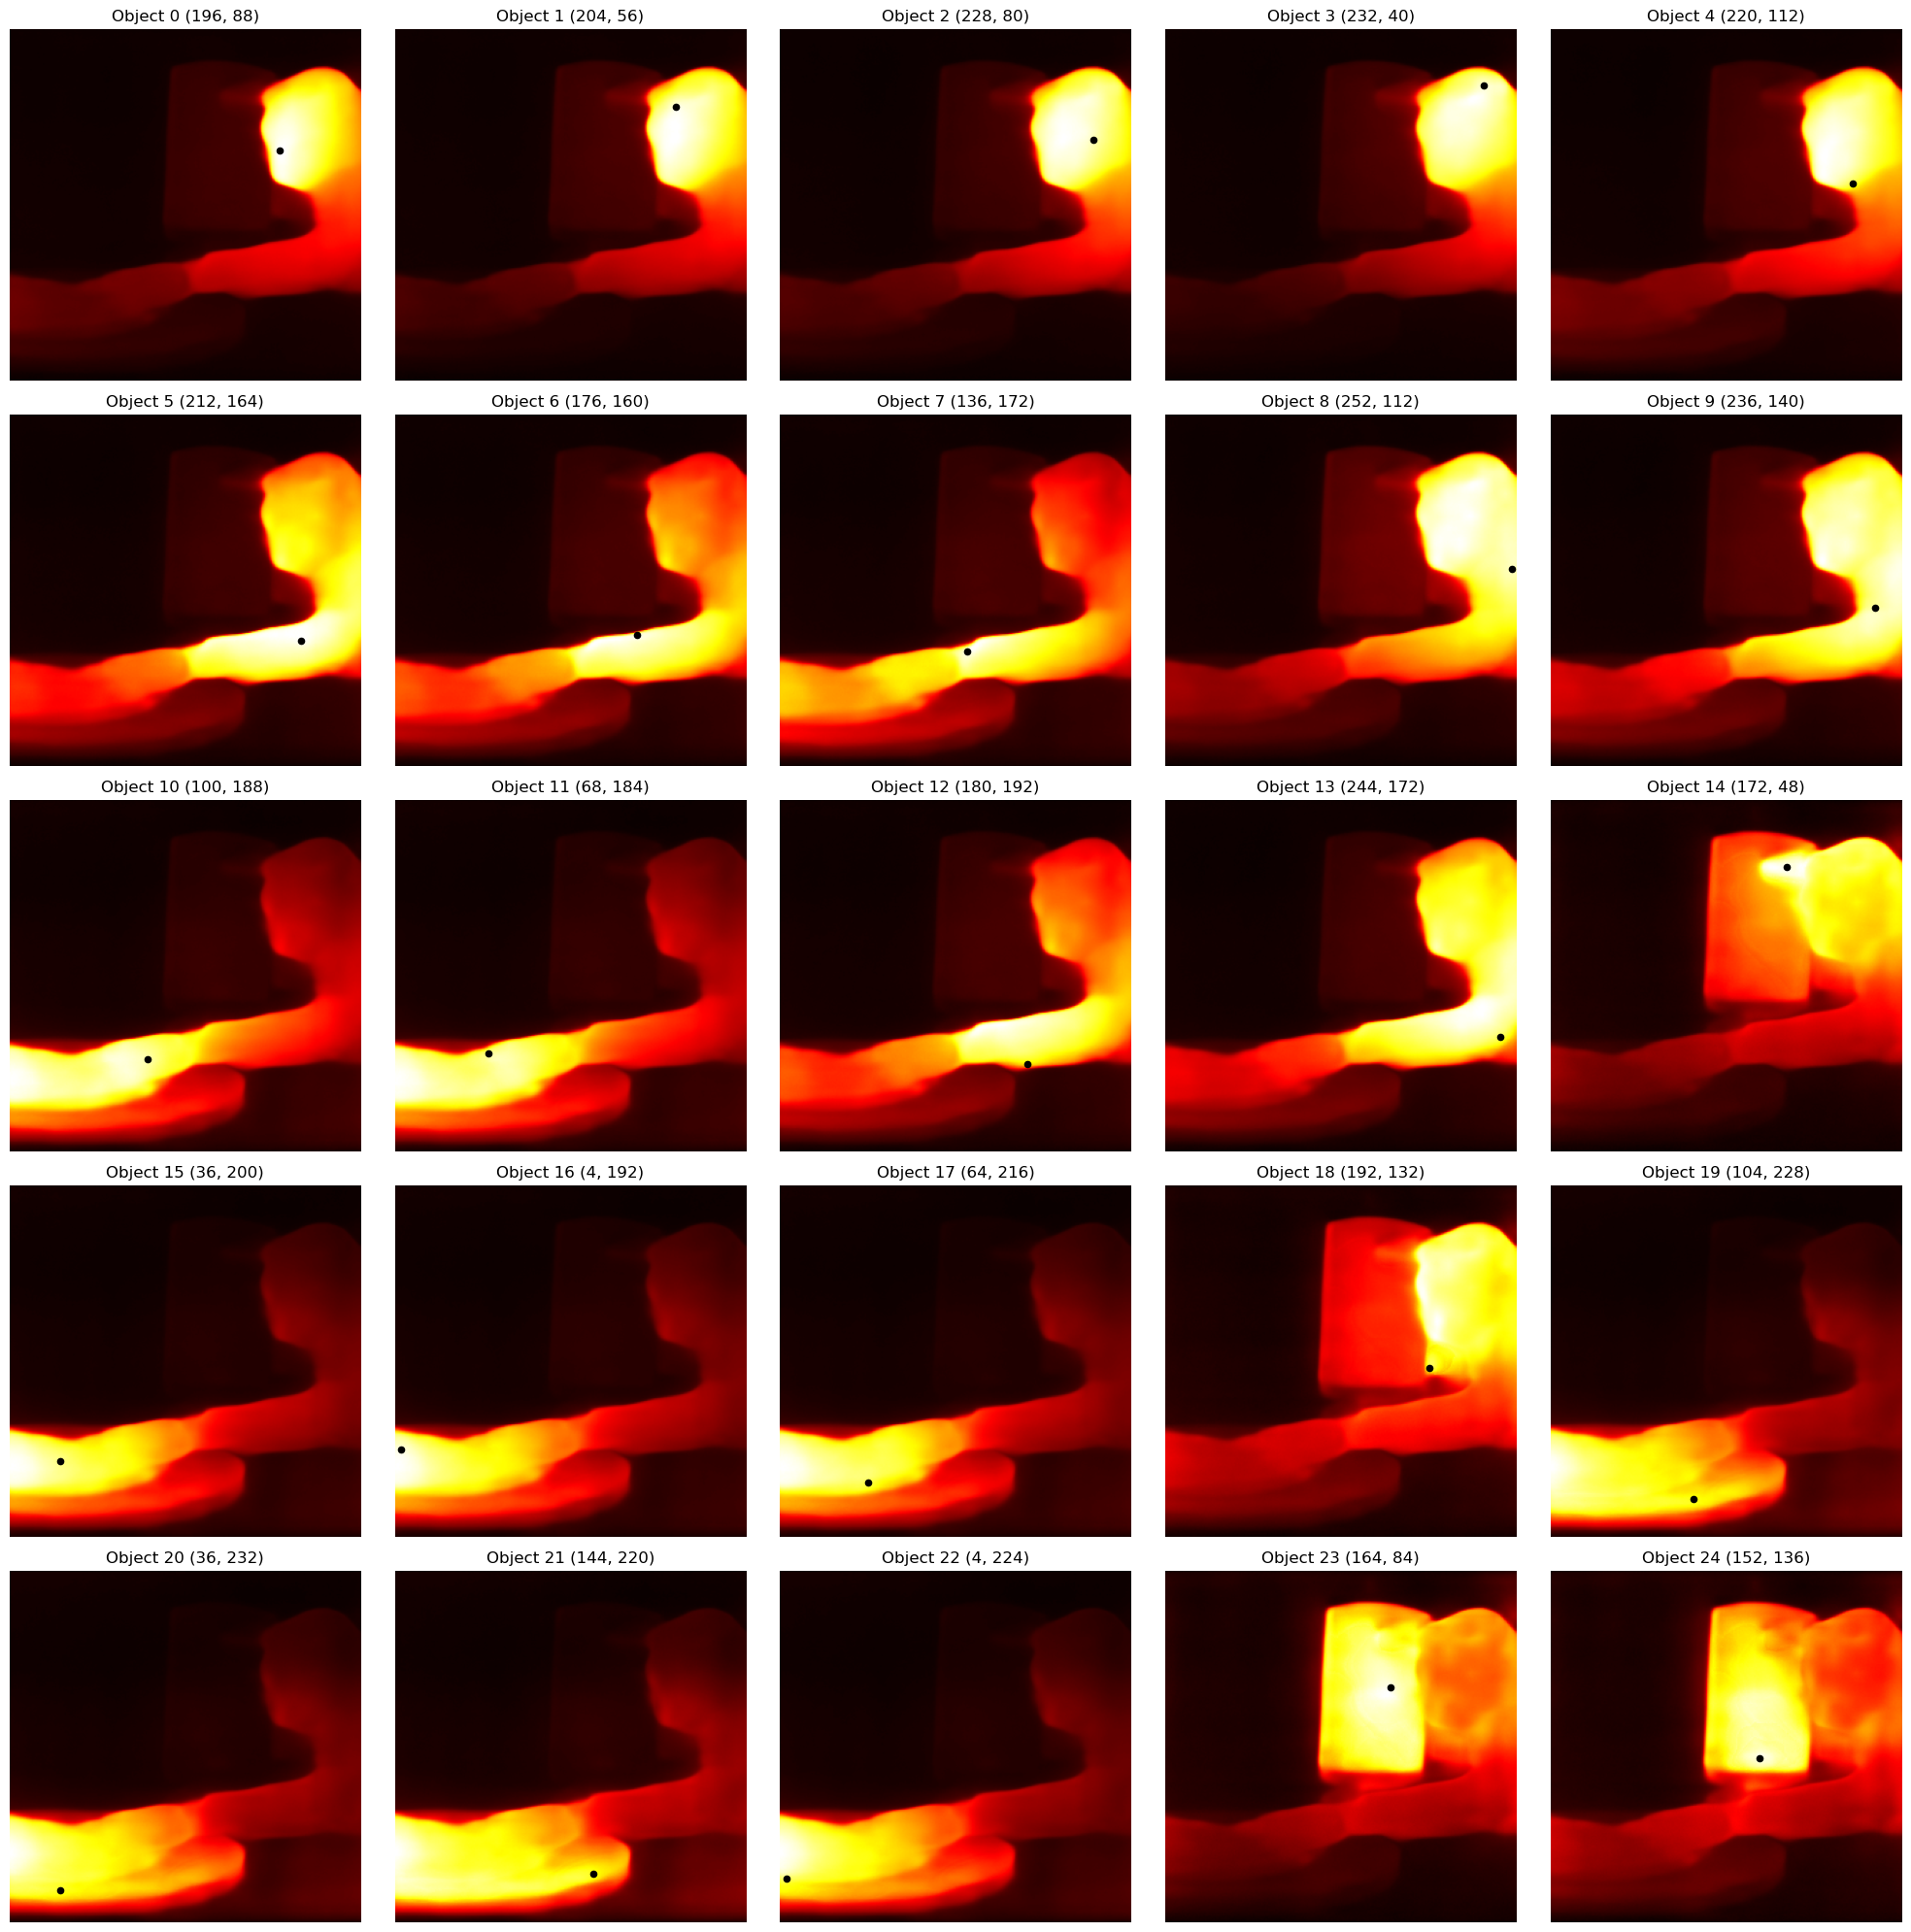

In [8]:
probe_pts_scaled = sampled_points * (256 / 64)  # Scale from 64x64 to 256x256
probe_pts_scaled = probe_pts_scaled.astype(int)

print(f"Using {len(probe_pts_scaled)} probe points")
visualize_affinity_slices_grid(affinity_matrix.cpu().numpy(), probe_pts_scaled)

Running iterative affinity segmentation...
Generated 13 segments before NMS
Final segments after NMS: 4


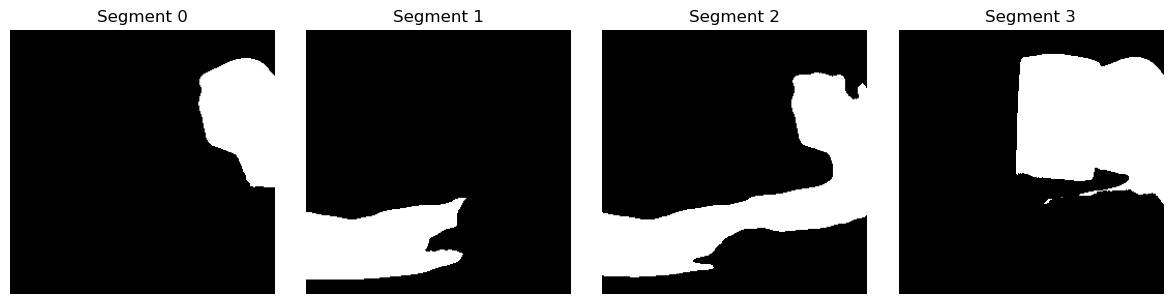

In [9]:
# Run iterative affinity segmentation
affinity_matrix_cpu = affinity_matrix.cpu().numpy()
print("Running iterative affinity segmentation...")

all_segments = iterative_affinity_segmentation(
    affinity_matrix_cpu, 
    probe_pts_scaled,  
    thresh=0.7, 
    min_size=50, 
    res=256
)

all_segments = np.stack(all_segments, 0)
print(f"Generated {len(all_segments)} segments before NMS")

# Apply NMS to remove overlapping segments
all_segments = mask_nms(all_segments, iou_thresh=0.5)
print(f"Final segments after NMS: {len(all_segments)}")

# Visualize
plot_segment_masks_row(all_segments)

## DO IT FOR ALL H5 FILES IN DIRECTORY

In [1]:
import glob
import h5py
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
from tqdm import tqdm
from scipy.ndimage import minimum_filter
from autoseg.utils import *

# Configuration
flow_h5_dir = '/ccn2/u/lilianch/external_repos/flow-poke-transformer/autosegp/flows_pmotion12_0.005minprob_8dist_final'
gt_dataset_path = '/ccn2/u/lilianch/data/550_openx_entity_dataset.h5'
result_save_dir = '/ccn2/u/lilianch/external_repos/flow-poke-transformer/autosegp/flows_pmotion12_0.005minprob_8dist_final/results/'

if not os.path.exists(result_save_dir):
    os.makedirs(result_save_dir, exist_ok=True)

all_h5s = sorted(glob.glob(f'{flow_h5_dir}/*.h5'))
print(f"Found {len(all_h5s)} H5 files to evaluate")

all_APs = []
all_ARs = []
all_ious = []
all_F1s = []

def get_miou(num_seg, iou_mat, arr_1, arr_2):
    all_mious = []
    for x in range(num_seg):
        miou = 0
        for ct, y in enumerate(arr_1):
            if y == x:
                miou = iou_mat[y, arr_2[ct]].mean()
        all_mious.append(miou)
    miou = np.mean(all_mious)
    return miou

num_proc = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for ct, f_ in enumerate(tqdm(all_h5s)):
    try:
        base_name = os.path.basename(f_).replace('.h5', '')
        
        # Load flow data
        with h5py.File(f_, 'r') as f:
            image = f['image'][:]
            flows = f['flows'][:]  # (N, num_offsets, 256, 256, 2)
            sampled_points = f['sampled_points'][:]  # (N, 2) in 64x64 coords
            prob_motion = f['prob_motion'][:]  # (64, 64)
        
        # Load GT segments from original dataset
        img_key = f"entityseg_{base_name.split('_')[-2]}_{base_name.split('_')[-1]}"
        with h5py.File(gt_dataset_path, 'r') as f_gt:
            if img_key not in f_gt:
                print(f"Warning: {img_key} not found in GT dataset, skipping...")
                continue
            segment_gt = f_gt[img_key]['segment'][:]
        
        # Scale sampled_points from 64x64 to 256x256 (flow space)
        probe_pts_valid = sampled_points * (256 / 64)
        probe_pts_valid = probe_pts_valid.astype(int)
        
        # Reshape flows for affinity computation
        # (N, num_offsets, 256, 256, 2) -> (256, 256, N*num_offsets, 2)
        N, num_offsets, H, W, C = flows.shape
        flow_reshaped = flows.transpose(2, 3, 0, 1, 4)  # (256, 256, N, num_offsets, 2)
        flow_reshaped = flow_reshaped.reshape(H, W, N * num_offsets, C)  # (256, 256, N*num_offsets, 2)
        
        # Flatten for affinity computation
        flow_flat_per_pixel = flow_reshaped.reshape(H, W, -1)  # (256, 256, N*num_offsets*2)
        flow_flat = flow_flat_per_pixel.reshape(-1, flow_flat_per_pixel.shape[-1])  # (256*256, N*num_offsets*2)
        
        # Compute affinity matrix
        flow_tensor = torch.from_numpy(flow_flat).float()
        affinity_matrix = compute_affinity_matrix(flow_tensor, device=device, batch_size=2048)
        
        # Run iterative affinity segmentation
        affinity_matrix_cpu = affinity_matrix.cpu().numpy()
        del affinity_matrix
        torch.cuda.empty_cache()
        
        all_segments = iterative_affinity_segmentation(
            affinity_matrix_cpu, probe_pts_valid, 
            thresh=0.5, res=256, min_size=50
        )
        all_segments = np.stack(all_segments, 0)
        all_segments = mask_nms(all_segments, iou_thresh=0.5)
        
        # Evaluate
        dict_result = evaluate_AP_AR_single_image(all_segments, segment_gt.astype('uint8'))
        
        # Save predicted segments
        save_path = os.path.join(result_save_dir, f'{base_name}.npy')
        np.save(save_path, all_segments)
        
        # Collect metrics
        all_ARs.append(dict_result['AR'])
        all_APs.append(dict_result['AP'])
        arr_1, arr_2 = dict_result['assignments']
        
        miou = get_miou(segment_gt.shape[0], dict_result['iou_mat'], arr_1, arr_2)
        all_ious.append(miou)
        
        AP = dict_result['AP']
        AR = dict_result['AR']
        F1 = 2 * AP * AR / (AP + AR + 1e-8)
        all_F1s.append(F1)
        
        num_proc += 1
        
        if num_proc % 10 == 0:
            print(f"\nProcessed {num_proc}/{len(all_h5s)} files")
            print(f"  Current mean AP: {np.mean(all_APs):.4f}")
            print(f"  Current mean AR: {np.mean(all_ARs):.4f}")
            print(f"  Current mean IoU: {np.mean(all_ious):.4f}")
            print(f"  Current mean F1: {np.mean(all_F1s):.4f}")
        
    except Exception as e:
        print(f"Error processing {f_}: {e}")
        import traceback
        traceback.print_exc()
        continue

# Final results
print("\n" + "="*80)
print("FINAL EVALUATION RESULTS")
print("="*80)
print(f"Total files processed: {num_proc}/{len(all_h5s)}")
print(f"AP:  {np.mean(all_APs):.4f}")
print(f"AR:  {np.mean(all_ARs):.4f}")
print(f"IoU: {np.mean(all_ious):.4f}")
print(f"F1:  {np.mean(all_F1s):.4f}")
print("="*80)

Found 26 H5 files to evaluate


 38%|█████████████████████████████████                                                     | 10/26 [01:24<02:15,  8.46s/it]


Processed 10/26 files
  Current mean AP: 0.2935
  Current mean AR: 0.1626
  Current mean IoU: 0.2954
  Current mean F1: 0.1957


 77%|██████████████████████████████████████████████████████████████████▏                   | 20/26 [02:48<00:46,  7.74s/it]


Processed 20/26 files
  Current mean AP: 0.2551
  Current mean AR: 0.1568
  Current mean IoU: 0.2556
  Current mean F1: 0.1814


100%|██████████████████████████████████████████████████████████████████████████████████████| 26/26 [03:42<00:00,  8.56s/it]


FINAL EVALUATION RESULTS
Total files processed: 26/26
AP:  0.2443
AR:  0.1505
IoU: 0.2378
F1:  0.1761


In [12]:
# comparing to ccwm numbers

AP:  0.3497943139257095
AR:  0.45580930769460554
iou:  0.565781591835331
F1:  0.38132490129900276